In [ ]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from imblearn.over_sampling import SMOTE

import shap
import lime
import lime.lime_tabular

from minisom import MiniSom

import tensorflow as tf

import folium
from geopy.geocoders import Nominatim

In [ ]:
df = pd.read_csv(r'E:\Machine Learning\Module 16\Heart-Disease-Analysis\heart.csv')
df.head()

In [11]:
df.info()
df.describe()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [37]:
numeric_df = df.select_dtypes(include=[np.number])

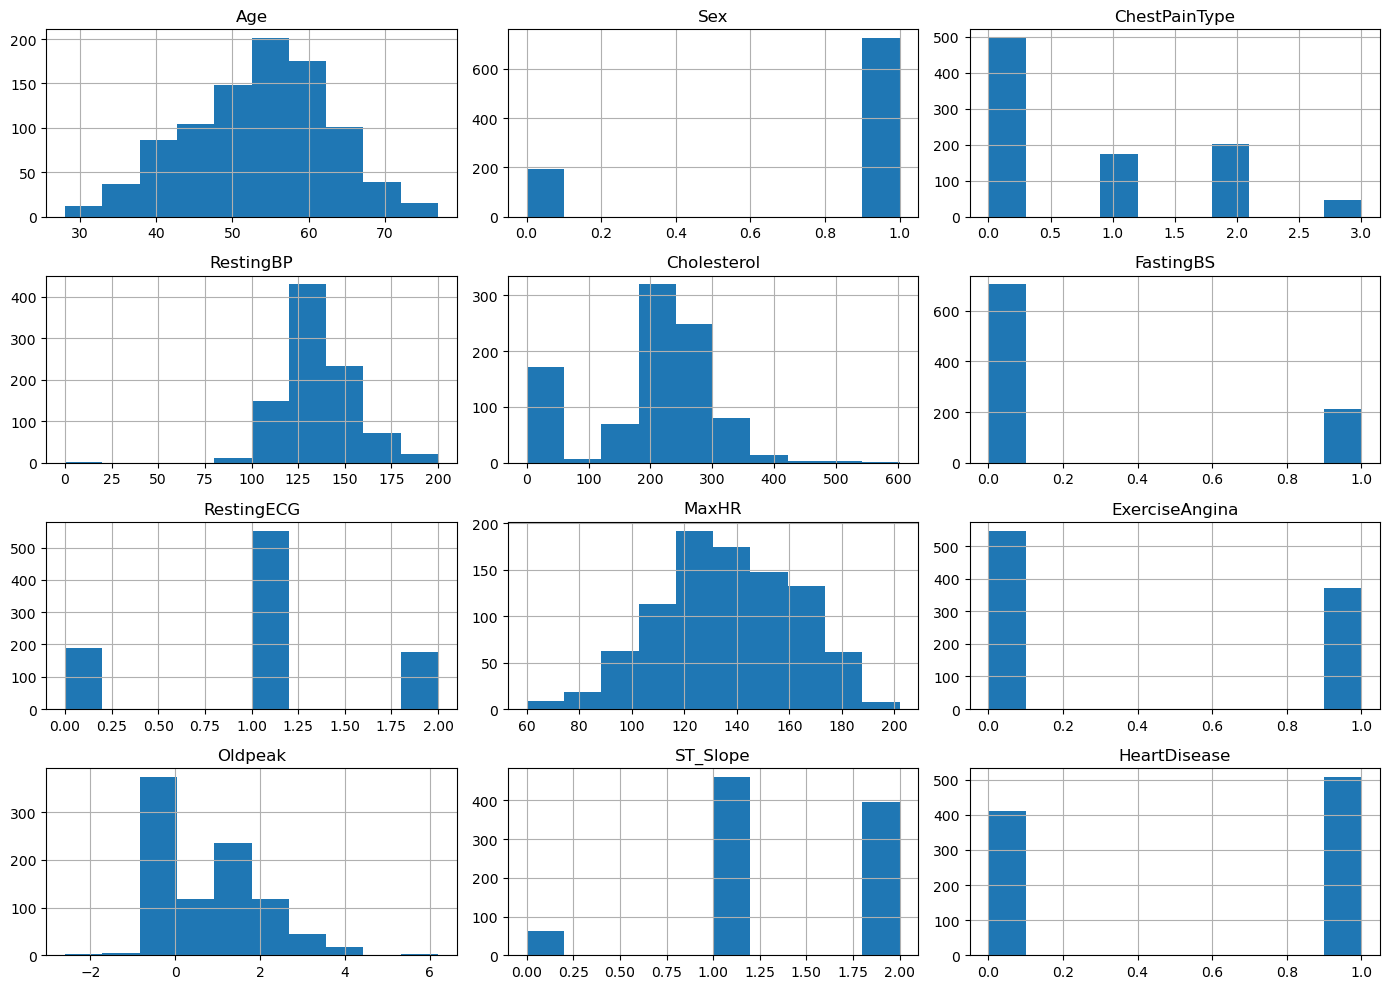

In [59]:
# Univariate plots
df.hist(figsize=(14, 10))
plt.tight_layout()
plt.show()

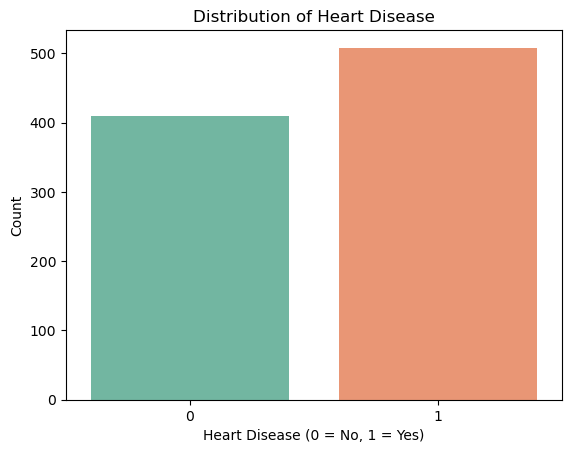

In [65]:
sns.countplot(x='HeartDisease', data=df, palette='Set2')
plt.title("Distribution of Heart Disease")
plt.xlabel("Heart Disease (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.show()

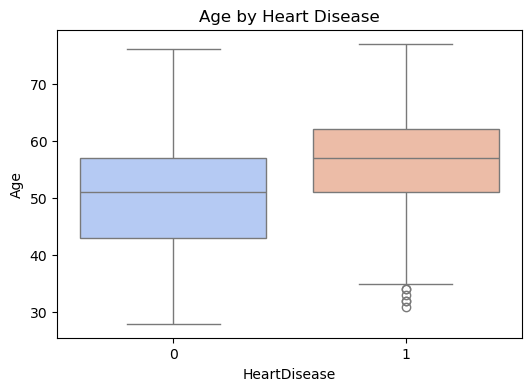

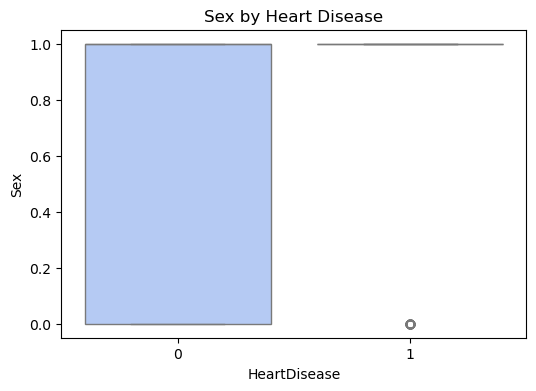

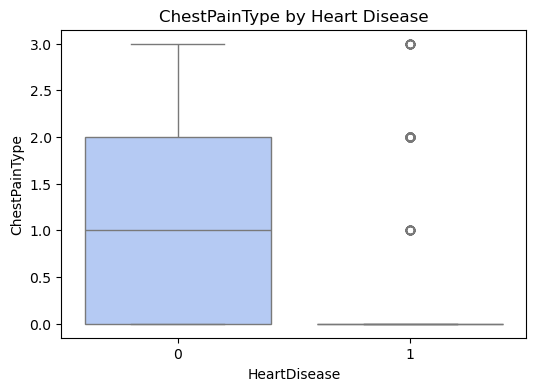

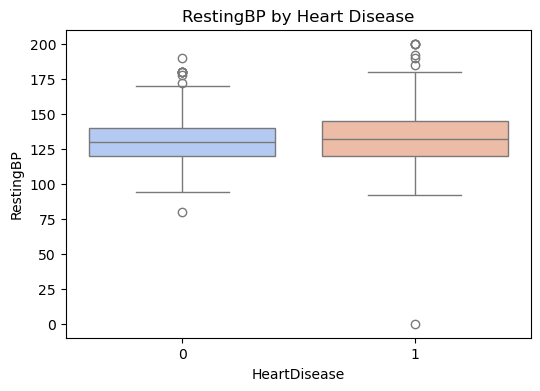

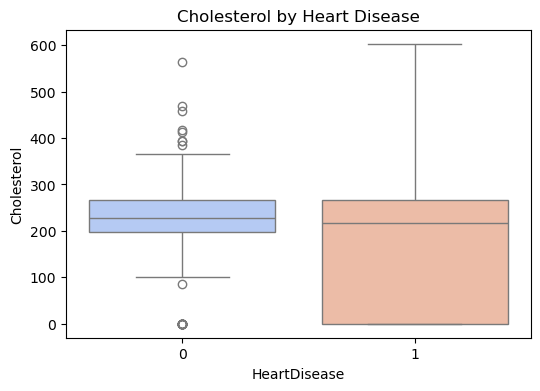

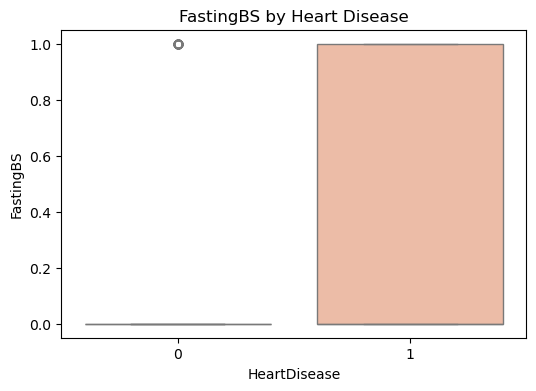

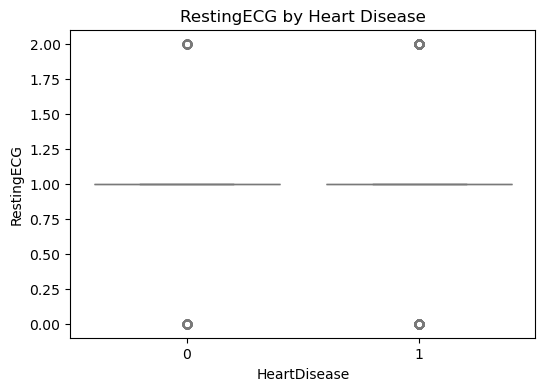

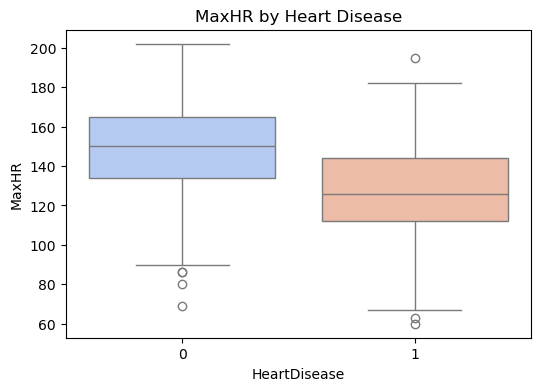

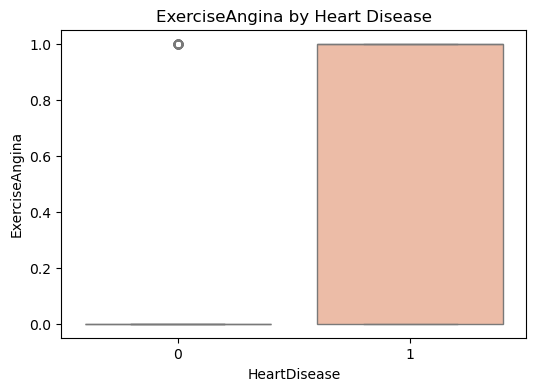

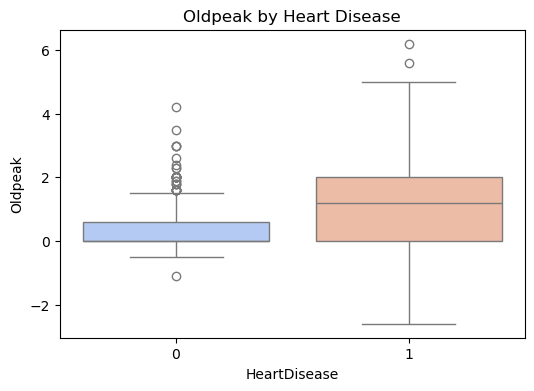

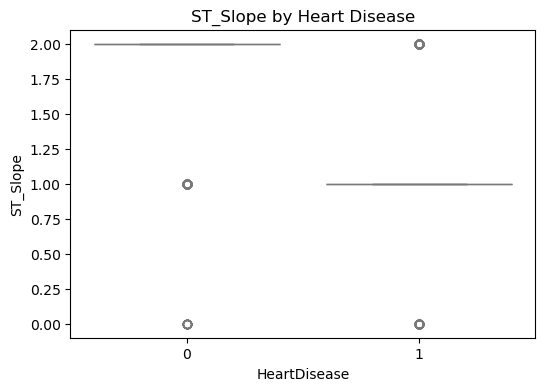

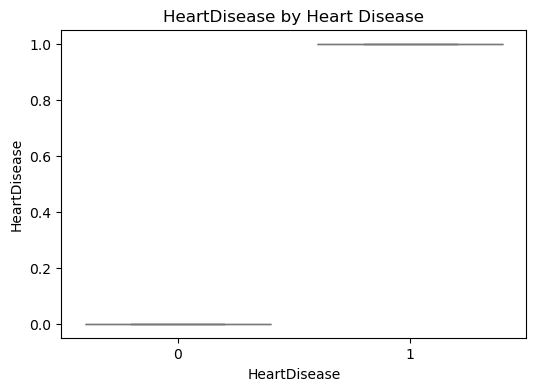

In [67]:
numerical_cols = df.select_dtypes(include=np.number).columns.tolist()

for col in numerical_cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x='HeartDisease', y=col, data=df, palette='coolwarm')
    plt.title(f"{col} by Heart Disease")
    plt.show()


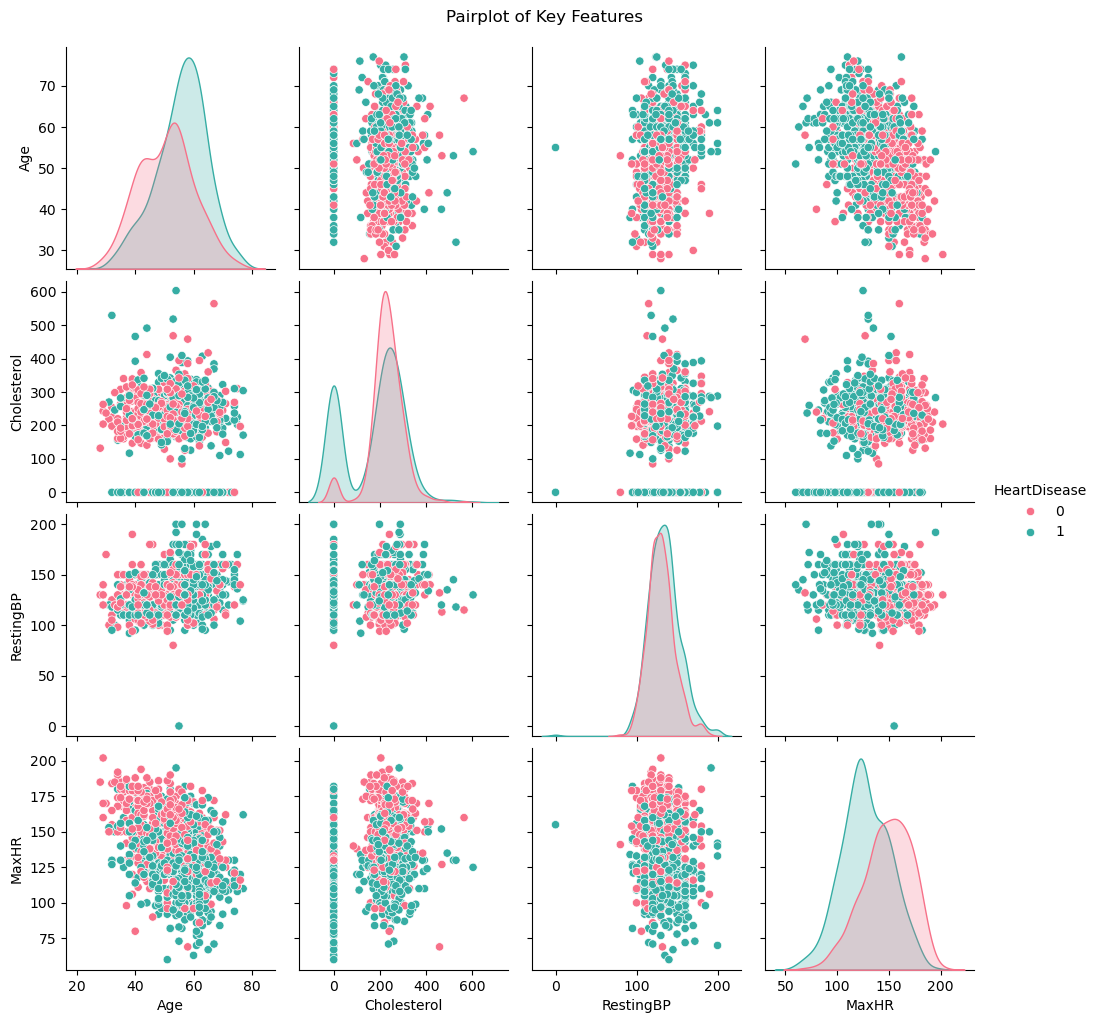

In [72]:
sns.pairplot(df[['Age', 'Cholesterol', 'RestingBP', 'MaxHR', 'HeartDisease']], hue='HeartDisease', palette='husl')
plt.suptitle("Pairplot of Key Features", y=1.02)
plt.show()

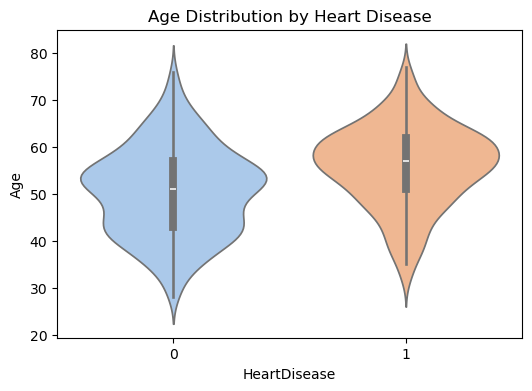

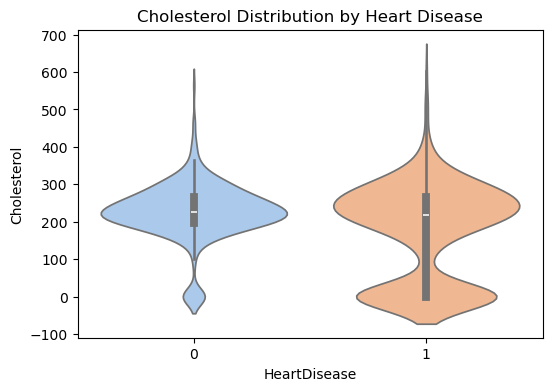

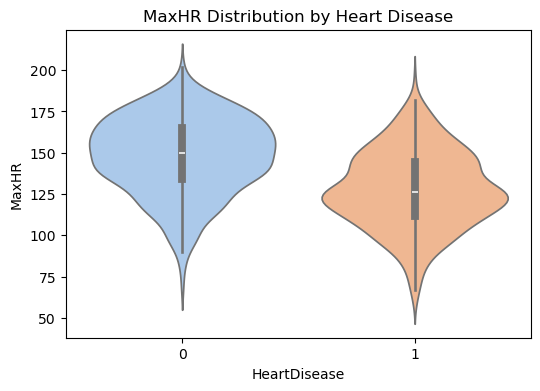

In [73]:
for col in ['Age', 'Cholesterol', 'MaxHR']:
    plt.figure(figsize=(6, 4))
    sns.violinplot(x='HeartDisease', y=col, data=df, palette='pastel')
    plt.title(f"{col} Distribution by Heart Disease")
    plt.show()

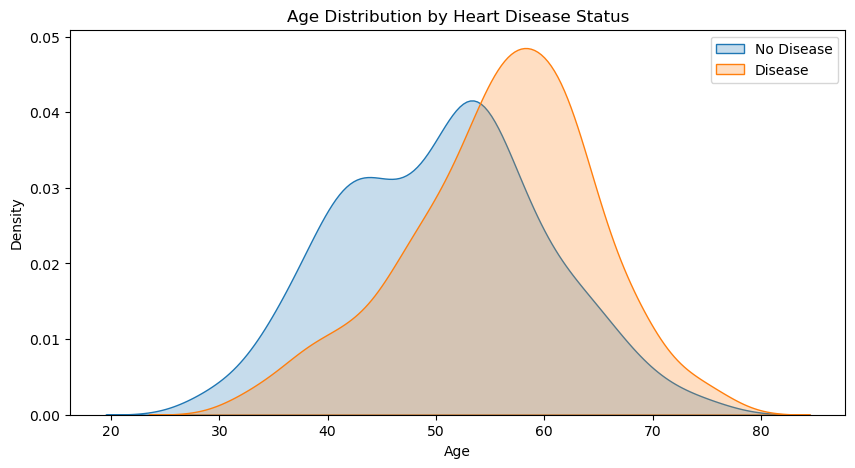

In [76]:
plt.figure(figsize=(10, 5))
sns.kdeplot(df[df['HeartDisease'] == 0]['Age'], label='No Disease', shade=True)
sns.kdeplot(df[df['HeartDisease'] == 1]['Age'], label='Disease', shade=True)
plt.title("Age Distribution by Heart Disease Status")
plt.xlabel("Age")
plt.legend()
plt.show()

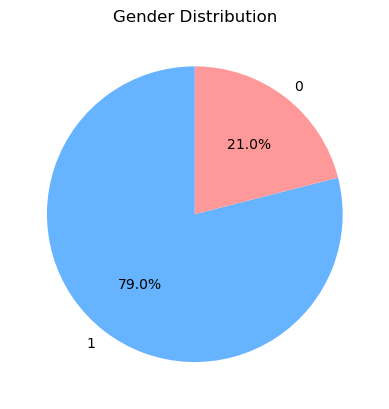

In [78]:
df['Sex'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['#66b3ff','#ff9999'])
plt.title("Gender Distribution")
plt.ylabel("")
plt.show()


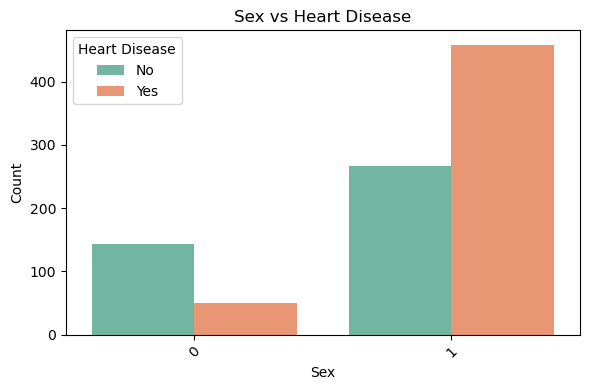

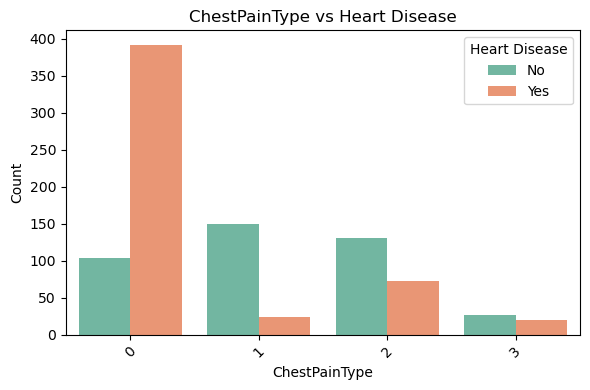

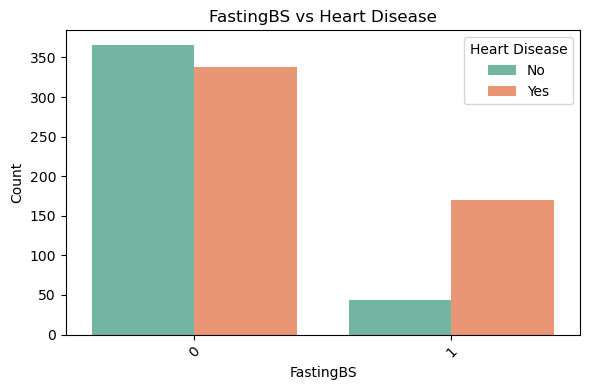

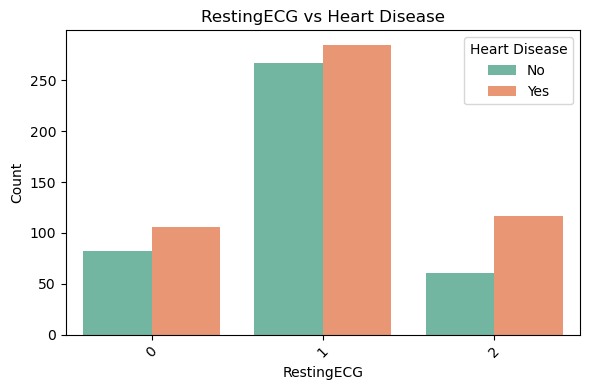

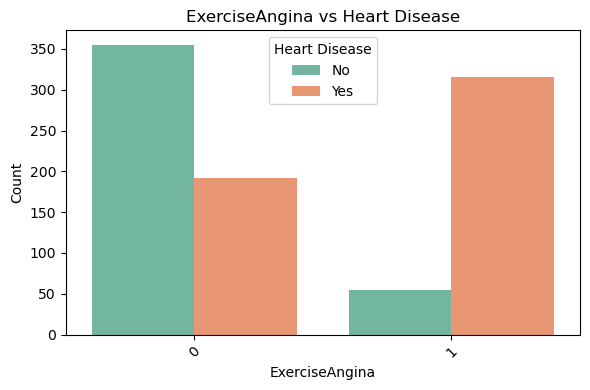

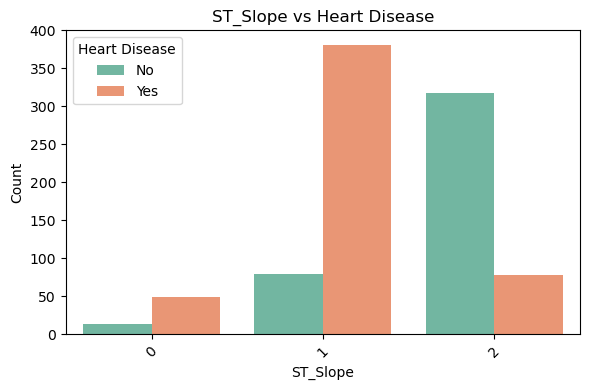

In [82]:
categorical_cols = ['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

for col in categorical_cols:
    if col in df.columns:
        plt.figure(figsize=(6, 4))
        sns.countplot(data=df, x=col, hue='HeartDisease', palette='Set2')
        plt.title(f"{col} vs Heart Disease")
        plt.xlabel(col)
        plt.ylabel("Count")
        plt.legend(title="Heart Disease", labels=["No", "Yes"])
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

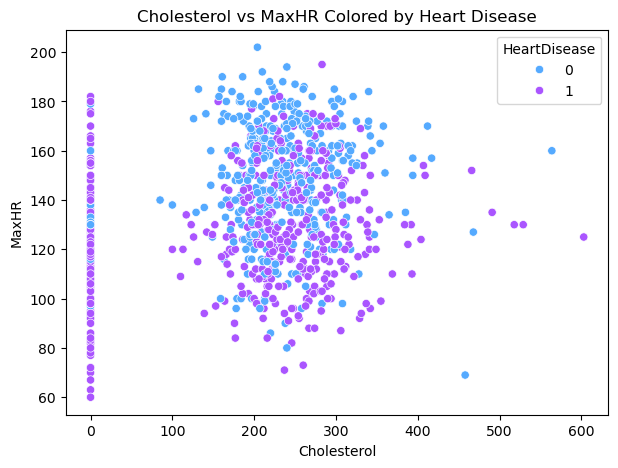

In [86]:
plt.figure(figsize=(7, 5))
sns.scatterplot(data=df, x='Cholesterol', y='MaxHR', hue='HeartDisease', palette='cool')
plt.title("Cholesterol vs MaxHR Colored by Heart Disease")
plt.show()

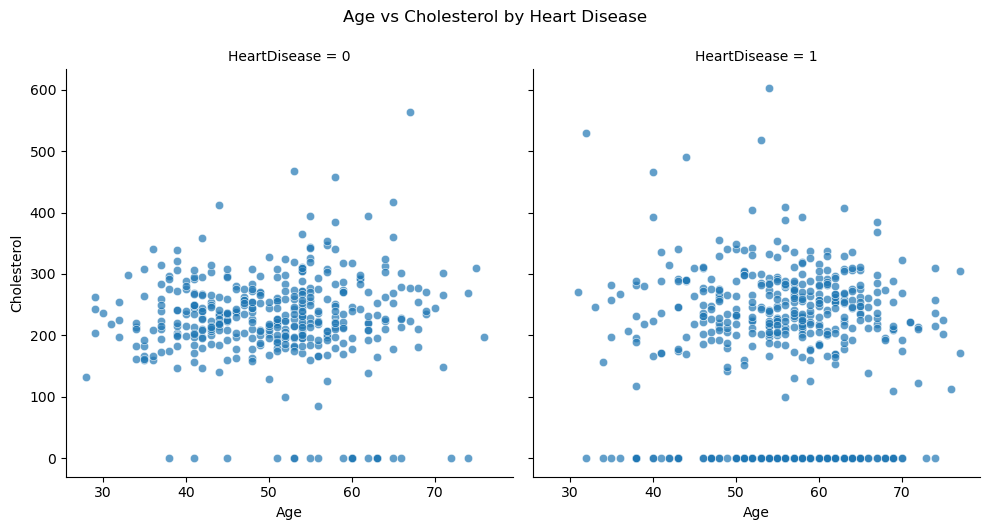

In [88]:
g = sns.FacetGrid(df, col='HeartDisease', height=5)
g.map_dataframe(sns.scatterplot, x='Age', y='Cholesterol', alpha=0.7)
g.set_axis_labels("Age", "Cholesterol")
g.fig.suptitle("Age vs Cholesterol by Heart Disease", y=1.05)
plt.show()

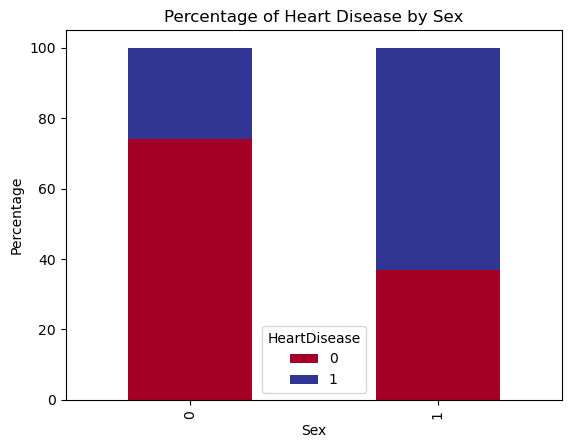

In [90]:
sex_disease = pd.crosstab(df['Sex'], df['HeartDisease'], normalize='index') * 100
sex_disease.plot(kind='bar', stacked=True, colormap='RdYlBu')
plt.title("Percentage of Heart Disease by Sex")
plt.ylabel("Percentage")
plt.show()


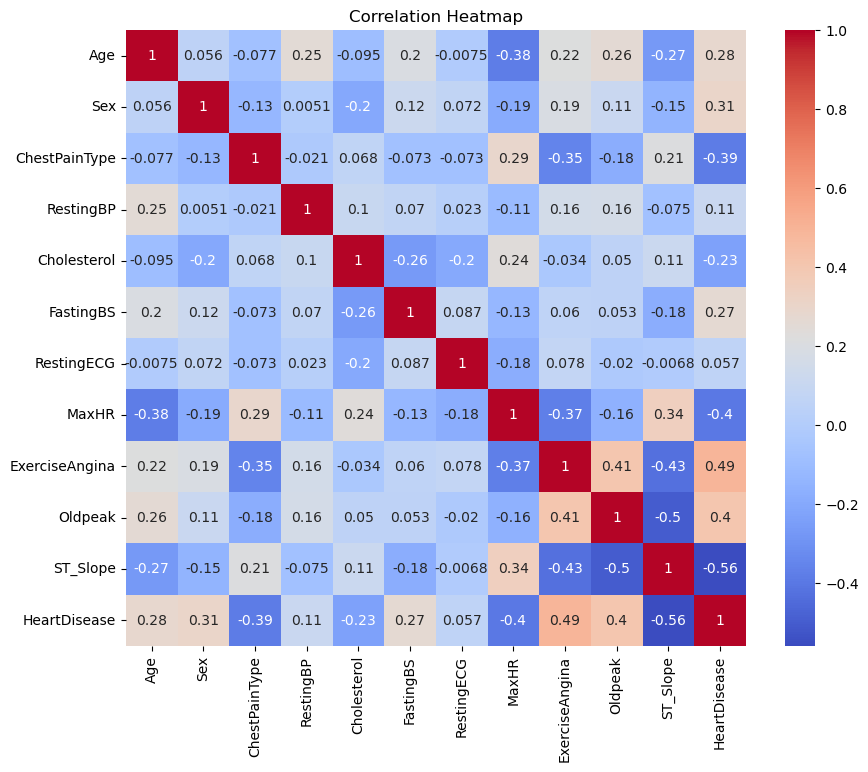

In [61]:
# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

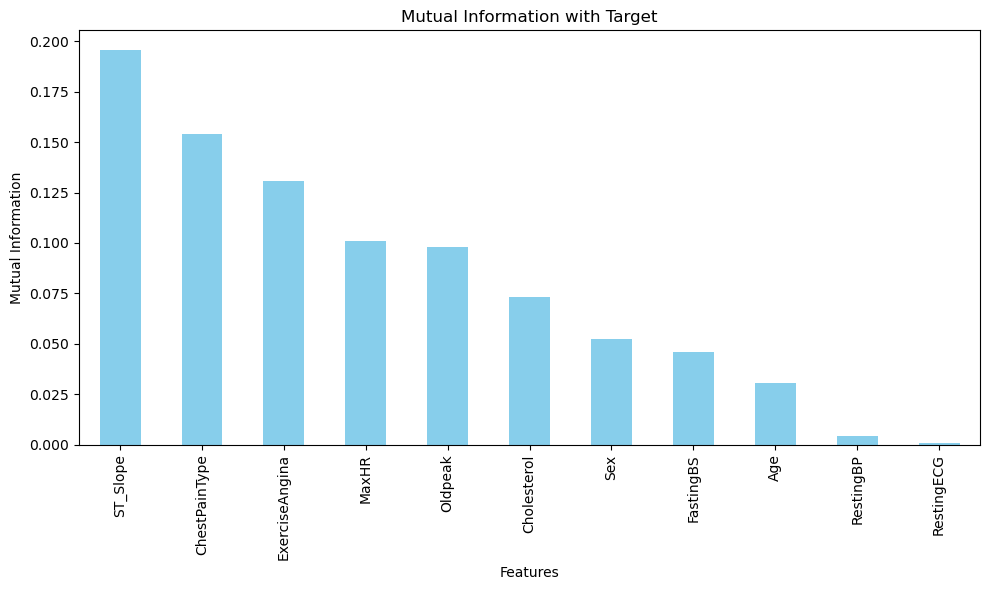

In [63]:
mutual_info = mutual_info_classif(X, y)
mi_series = pd.Series(mutual_info, index=X.columns)

# Plot the mutual information scores
mi_series.sort_values(ascending=False).plot(kind='bar', figsize=(10, 6), color='skyblue')
plt.title("Mutual Information with Target")
plt.ylabel("Mutual Information")
plt.xlabel("Features")
plt.tight_layout()
plt.show()

In [41]:
from sklearn.preprocessing import LabelEncoder

# Encode categorical features
label_encoders = {}
for col in df.select_dtypes(include='object').columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

X = df.drop("HeartDisease", axis=1)
y = df["HeartDisease"]

# Balance dataset using SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)


In [43]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)



Evaluating Model: Logistic Regression

Accuracy: 0.8431



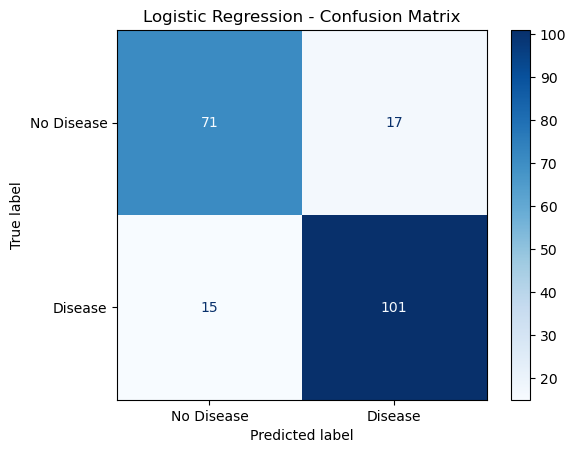

Classification Report:
              precision    recall  f1-score   support

  No Disease       0.83      0.81      0.82        88
     Disease       0.86      0.87      0.86       116

    accuracy                           0.84       204
   macro avg       0.84      0.84      0.84       204
weighted avg       0.84      0.84      0.84       204


------------------------------------------------------------

Evaluating Model: Decision Tree

Accuracy: 0.8382



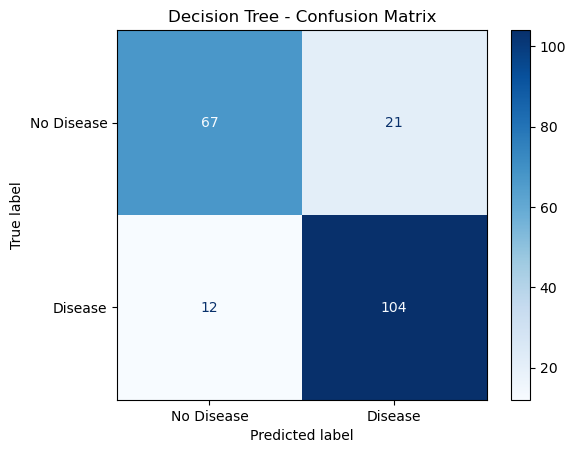

Classification Report:
              precision    recall  f1-score   support

  No Disease       0.85      0.76      0.80        88
     Disease       0.83      0.90      0.86       116

    accuracy                           0.84       204
   macro avg       0.84      0.83      0.83       204
weighted avg       0.84      0.84      0.84       204


------------------------------------------------------------

Evaluating Model: KNN

Accuracy: 0.7059



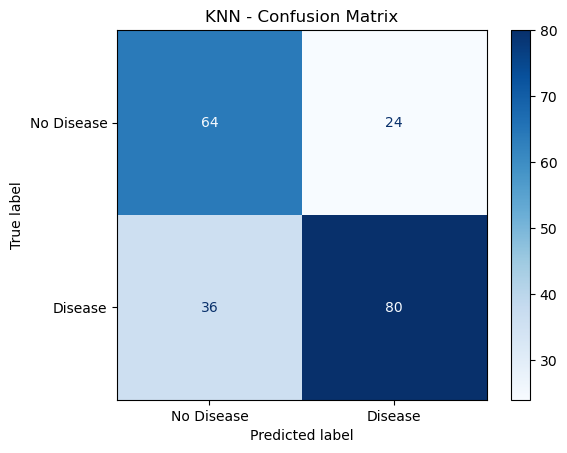

Classification Report:
              precision    recall  f1-score   support

  No Disease       0.64      0.73      0.68        88
     Disease       0.77      0.69      0.73       116

    accuracy                           0.71       204
   macro avg       0.70      0.71      0.70       204
weighted avg       0.71      0.71      0.71       204


------------------------------------------------------------


In [94]:
from sklearn.metrics import ConfusionMatrixDisplay

for name, model in models.items():
    print(f"\n{'='*30}")
    print(f"Evaluating Model: {name}")
    print(f"{'='*30}\n")
    
    # Fit and predict
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    
    # Accuracy
    acc = accuracy_score(y_test, preds)
    print(f"Accuracy: {acc:.4f}\n")
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Disease", "Disease"])
    disp.plot(cmap='Blues')
    plt.title(f"{name} - Confusion Matrix")
    plt.show()
    
    # Classification Report
    print("Classification Report:")
    print(classification_report(y_test, preds, target_names=["No Disease", "Disease"]))
    print("\n" + "-"*60)


In [47]:
kfold = StratifiedKFold(n_splits=5)
for name, model in models.items():
    results = cross_val_score(model, X_res, y_res, cv=kfold)
    print(f"{name} - CV Mean Accuracy: {results.mean():.4f}")


Logistic Regression - CV Mean Accuracy: 0.8169
Decision Tree - CV Mean Accuracy: 0.8021
KNN - CV Mean Accuracy: 0.6812


In [49]:
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X.columns,
    class_names=["No Disease", "Disease"],
    mode='classification'
)

i = 0
exp = explainer.explain_instance(X_test.iloc[i], models["Logistic Regression"].predict_proba)
exp.show_in_notebook()


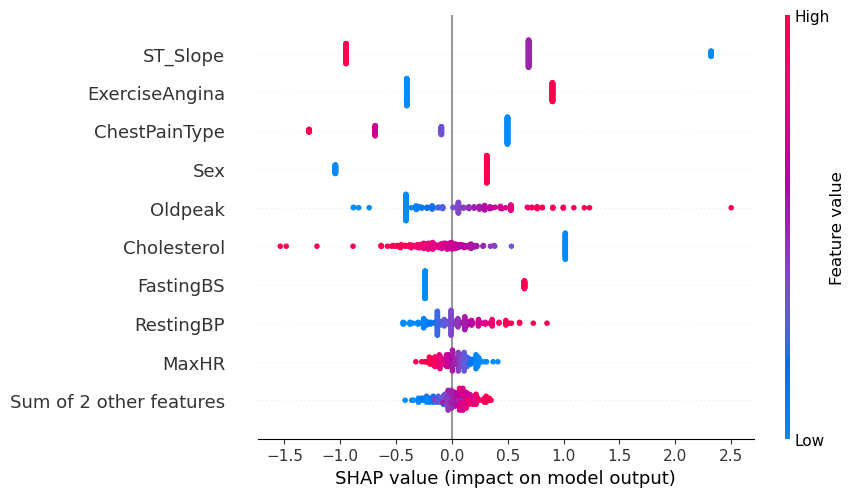

In [51]:
explainer_shap = shap.Explainer(models["Logistic Regression"], X_train)
shap_values = explainer_shap(X_test)
shap.plots.beeswarm(shap_values)


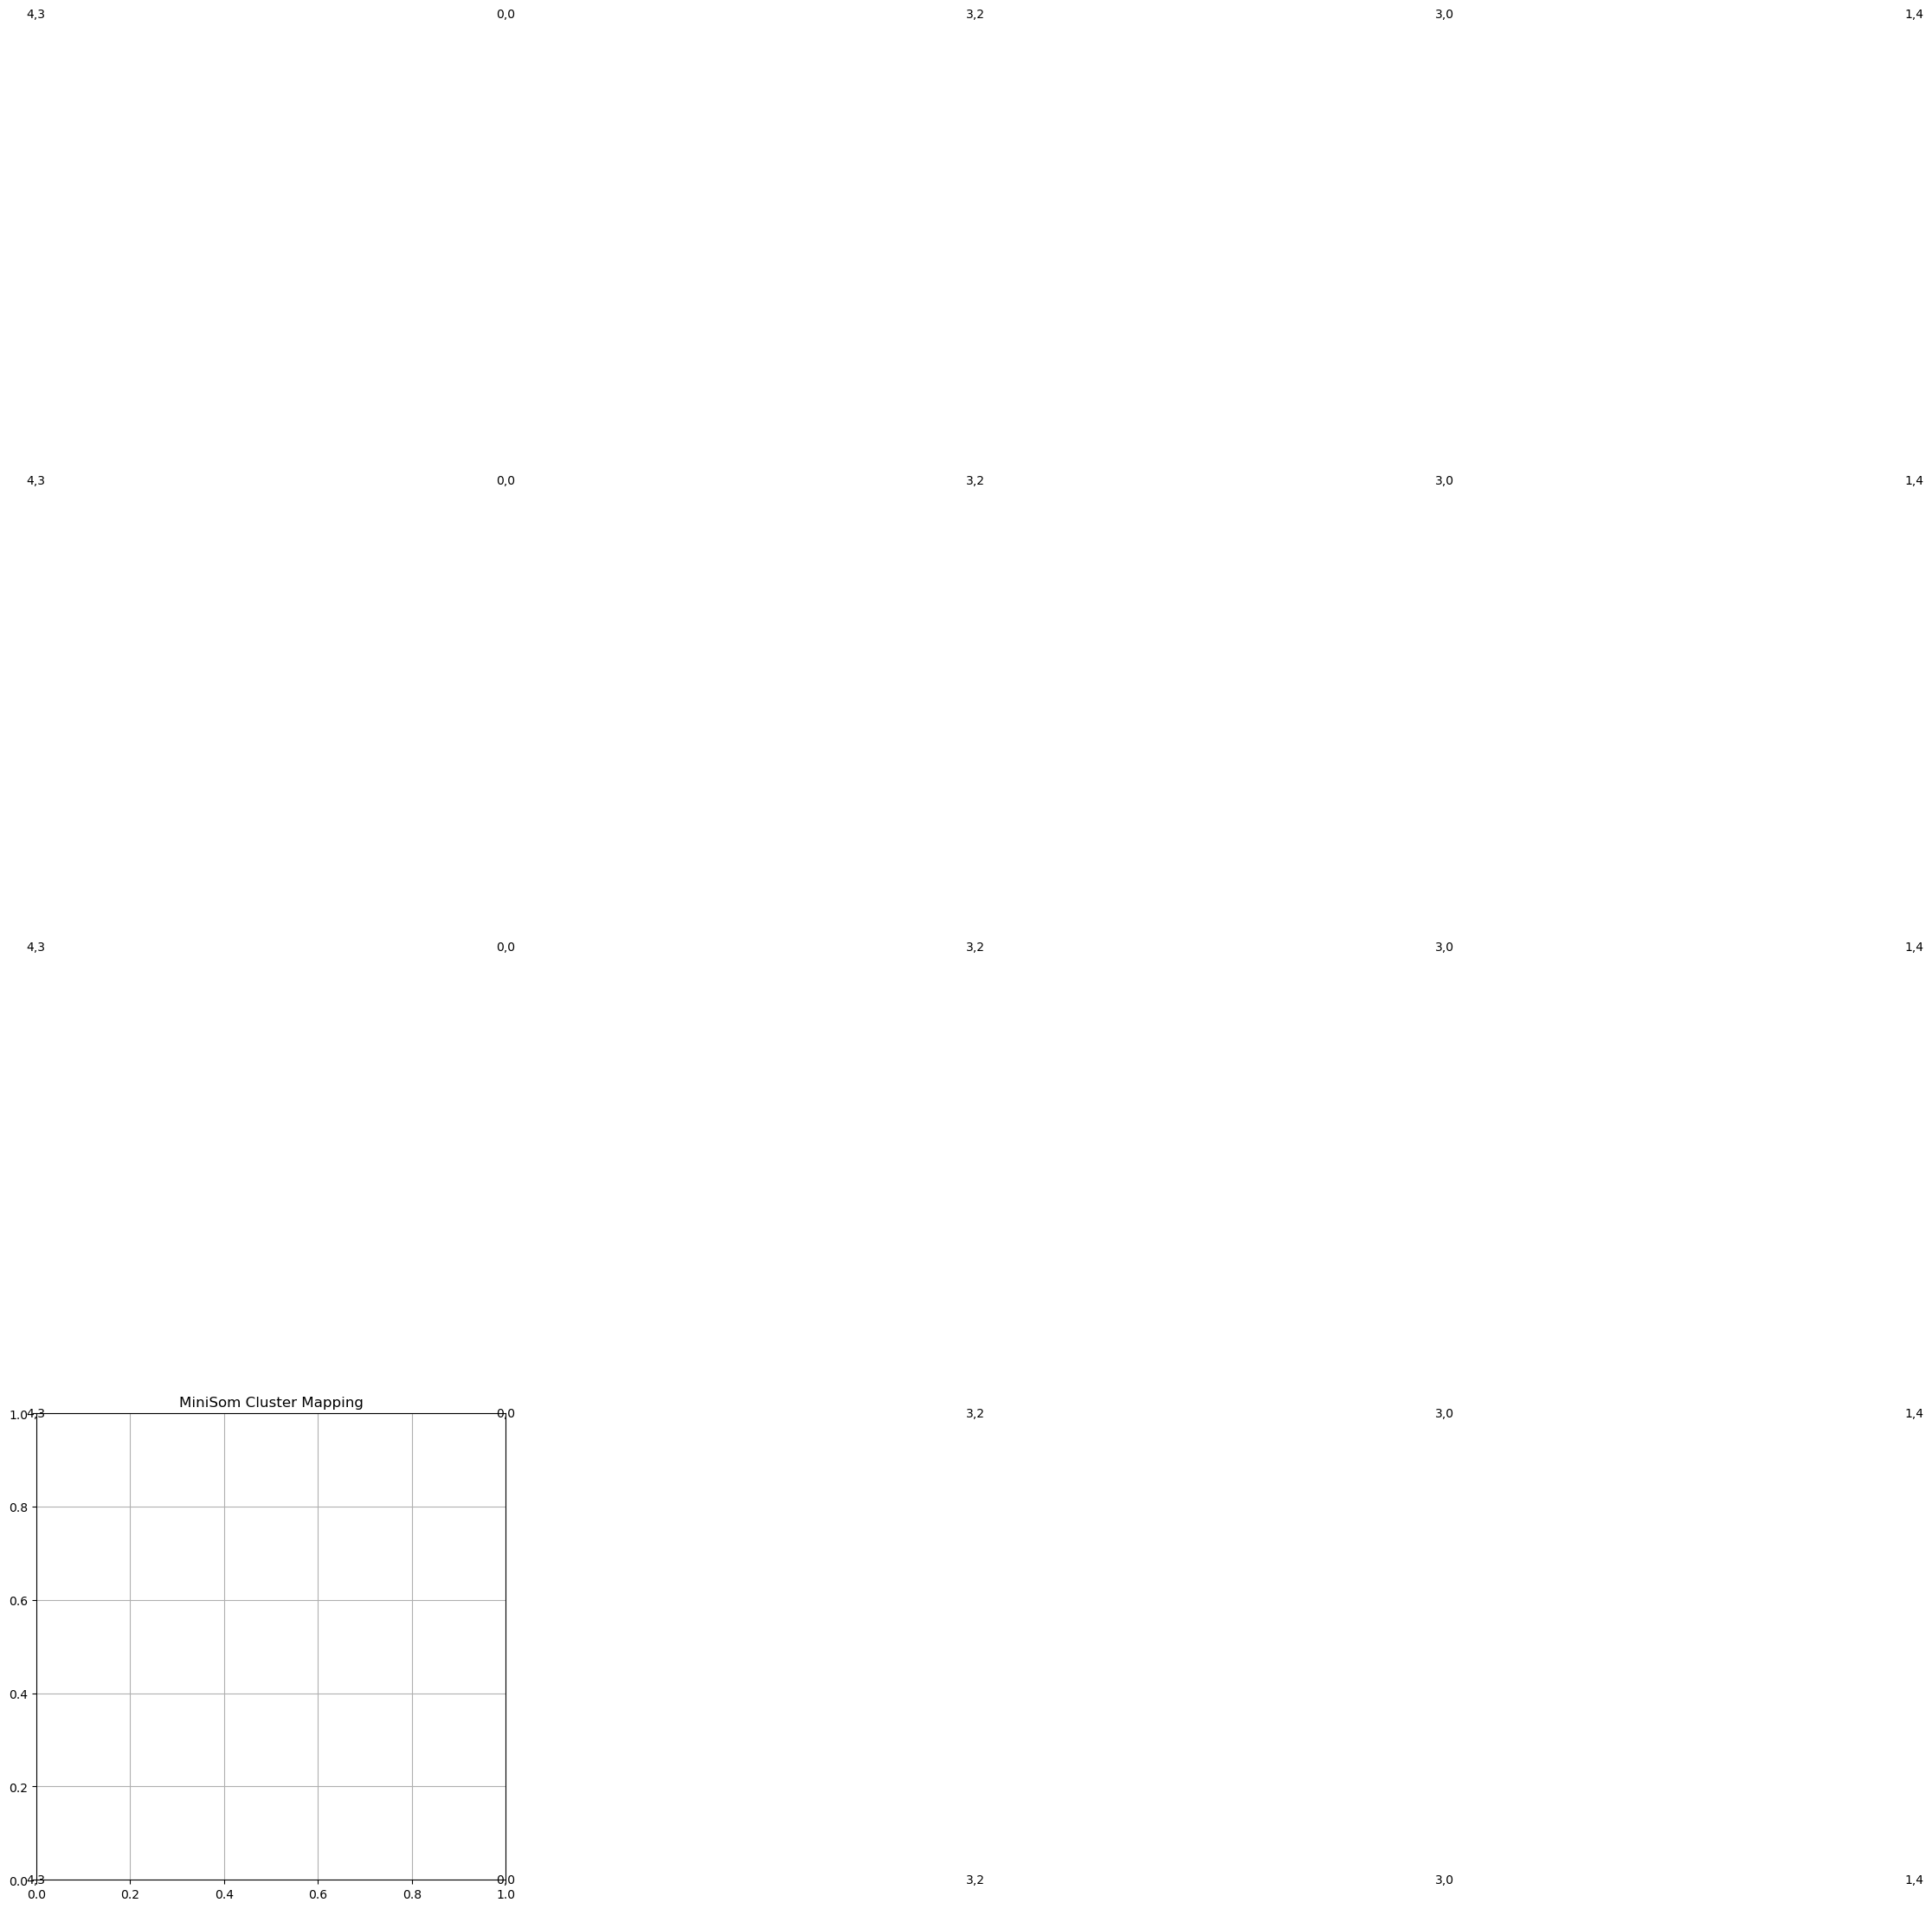

In [53]:
som = MiniSom(5, 5, len(X.columns), sigma=0.5, learning_rate=0.5)
som.random_weights_init(X_res.values)
som.train_random(X_res.values, 100)

# Visualizing SOM weights
plt.figure(figsize=(7, 7))
for i in range(5):
    for j in range(5):
        plt.text(i, j, str(som.winner(X_res.values[i])[0]) + "," + str(som.winner(X_res.values[i])[1]),
                 ha='center', va='center')
plt.grid()
plt.title("MiniSom Cluster Mapping")
plt.show()
